In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from sklearn.model_selection import train_test_split

In [9]:
class AugmentedCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4), # randomly crops an image to a size of 32x32 pixels, while padding the image with 4 pixels on each side before cropping.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2) # randomly changes the brightness, contrast, saturation, and hue of an image by up to 20%.
        ])

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.train:
            img = self.augment(img)
        img = np.array(img)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        if self.transform is not None:
            img = self.transform(img)

        return img, target


In [10]:
transform = transforms.Compose([
    transforms.ToTensor(), # Converts an image to a tensor, which can then be used as input to a PyTorch model.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes an image by subtracting the mean of (0.5, 0.5, 0.5) and dividing by the standard deviation of (0.5, 0.5, 0.5). After normalizing, the pixel values will range from -1 to 1.
])

# Datasets
trainset = AugmentedCIFAR10(root='./data', train=True,
                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
           'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # `3` is the number of input channels for a colored image.
        # `6` is the number of output channels (neurons). It is a hyperparameter.
        # `5` is the kernel size (5x5 pixels).
        self.conv1 = nn.Conv2d(3, 6, 5)
        # `2` is the kernel size (2x2 pixels) of the pooling operation.
        # `2` is the stride of the pooling operation.
        self.pool = nn.MaxPool2d(2, 2)
        # `6` is the number of input channels which must be equal to the number of output channels in the previous layer.
        # `16` is the number of output channels (neurons). It is a hyperparameter.
        # `5` is the kernel size (5x5 pixels).
        self.conv2 = nn.Conv2d(6, 16, 5)
        # `16*5*5` is the number of input channels which must be equal to the number of output channels in the previous layer. We have 16 neurons in the previous channel each being 5x5. Therefore, the total would be 16*5*5.
        # `120` is the number of output channels (neurons). It is a hyperparameter.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # `120` is the number of input channels which must be equal to the number of output channels in the previous layer.
        # `84` is the number of output channels (neurons). It is a hyperparameter.
        self.fc2 = nn.Linear(120, 84)
        # `84` is the number of input channels which must be equal to the number of output channels in the previous layer.
        # `10` is the number of output channels (neurons). In classification problems, it must be equal to the number of possible classes.
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # `relu` is the activation function.
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # `view` is used to reshape the tensor. It is to prepare the data before feeding it to a fully connected layar. `Flatten` can also be used for the same prupose.
        # `-1` tells PyTorch to automatically infer the first dimension of the tensor which is the number of batch size used in the training parameters.
        # `16*5*5` is the number of input channels which must be equal to the number of output channels in the previous layer. We have 16 neurons in the previous channel each being 5x5. Therefore, the total would be 16*5*5.
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [6]:
model = CNN()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Initialize TensorBoard
writer = SummaryWriter('runs/cifar10_experiment')


In [14]:
# `2` is the number of training iterations. It is a hyperparameter.
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # It is used to zero out the gradients of all the parameters in the optimizer.
        # This is to avoid gradient accumulation from previous iterations which can lead to inaccurate updates to the model parameters.
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}')
            writer.add_scalar('training loss',
                              running_loss / 2000,
                              epoch * len(trainloader) + i)
            running_loss = 0.0

print('Finished Training')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1, 2000] loss: 2.235
[1, 4000] loss: 2.005
[1, 6000] loss: 1.880
[1, 8000] loss: 1.792
[1, 10000] loss: 1.746
[1, 12000] loss: 1.705


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[2, 2000] loss: 1.668
[2, 4000] loss: 1.653
[2, 6000] loss: 1.615
[2, 8000] loss: 1.622
[2, 10000] loss: 1.596
[2, 12000] loss: 1.584
Finished Training


In [ ]:
# Evaluate the model on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# Write the accuracy to TensorBoard
writer.add_scalar('accuracy',
                   100 * correct / total,
                   epoch * len(trainloader) + i)

writer.close()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


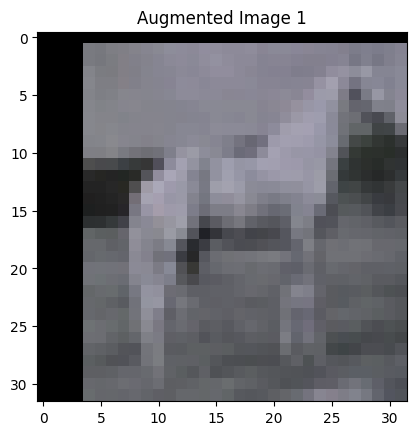

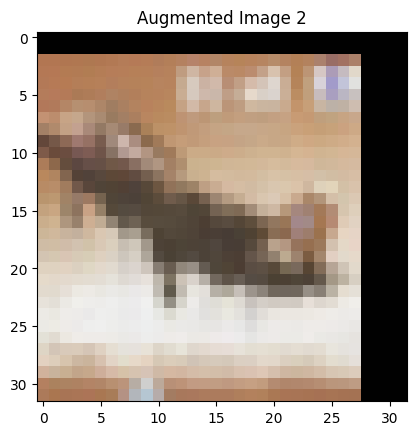

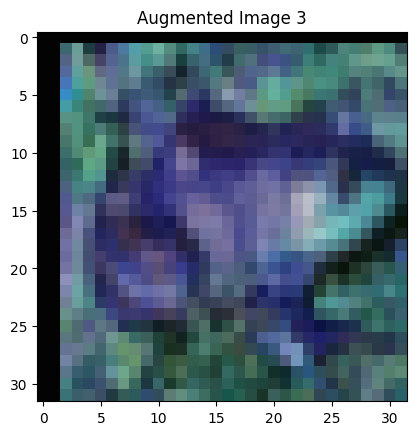

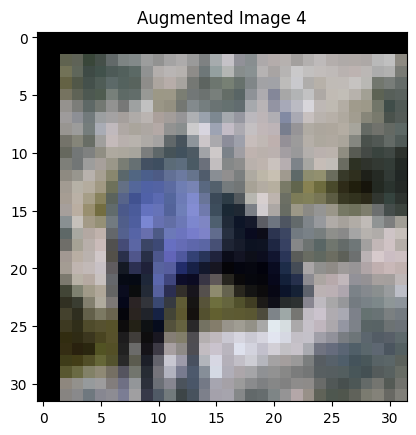

GroundTruth:    cat  ship  ship plane
Predicted:  horse  ship truck  ship


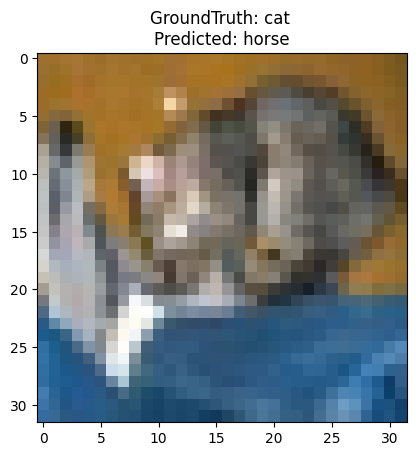

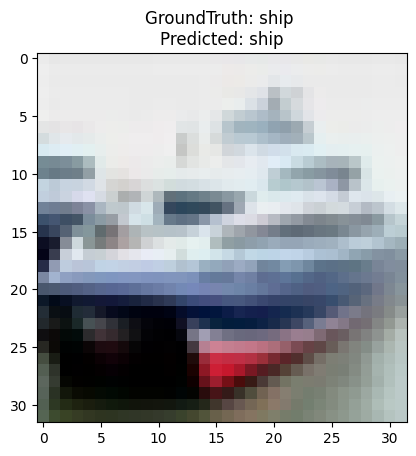

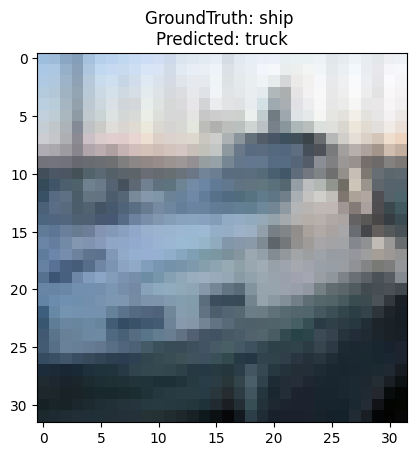

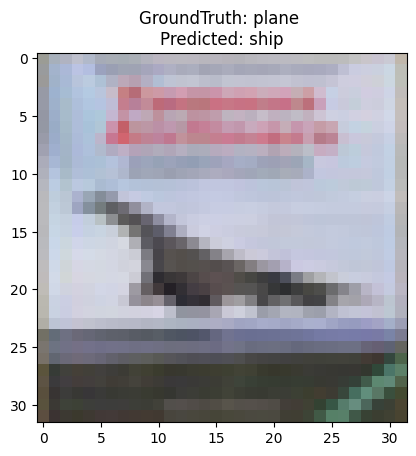

In [21]:
def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Visualize some of the predictions
dataiter = iter(testloader)
images, labels = next(dataiter)

# Print images with predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

# Show images with predictions
for i in range(4):
    imshow(images[i], f'GroundTruth: {classes[labels[i]]} \nPredicted: {classes[predicted[i]]}')